### Old Code

Mistake corrected here: **radd function was still doing other + self causing a never ending recursion to the same function**

In [40]:
from typing import Tuple, Optional, List
from __future__ import annotations
import math

class Value:
    '''Lowest unit of this activity. Represents a value, on which we will do operations, differentiation etc.
       I need to keep track of: Value, operation that created it, parents that led to its creation, differentiation function?
    '''
    def __init__(self, data: float, name: Optional[str] = '', _op: str = None, _parents: Tuple['Value'] = ()) -> None:
        self.data = data
        self._backward = lambda : None
        self._op = _op
        self._parents = _parents
        self.name = name
        self.grad = 0.0

    def __repr__(self) -> str:
        '''way to recreate the value object, meant for developers'''
        return f'Value(data={self.data}, name={self.name}, op={self._op})'

    def __add__(self, other: Value) -> Value:
        '''a+b, where a and b are Value objects, a.__add__(b) called'''
        if isinstance(other, (int, float)):
            other = Value(other)
        out = Value(self.data + other.data, _op='+', _parents=(self, other))
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
        
    def __mul__(self, other: Value) -> Value:
        '''a*b, where a and b are Value objects, a.__mul__(b) called'''
        if isinstance(other, (int, float)):
            other = Value(other)
        
        out = Value(self.data * other.data, _op='*', _parents=(self, other))
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        '''when b*a called, where b is a scalar, a.__rmul__(b) called.'''
        return self * other
    
    def __radd__(self, other):
        '''when b+a called, where b is a scalar, a.__radd__(b) called.'''
        return self + other
    
    def __pow__(self, other: float):
        '''when we call a ** b, a.__pow__(b) is called, where b is a scalar.'''
        if not isinstance(other, (int, float)):
            raise ValueError("Trying to calculate exp on an incompatible data type. Only supporting int and float.")
        out = Value(self.data ** other, _op=f'**{other}', _parents=(self, ))
        def _backward():
            self.grad += other * (self.data ** (other -1)) * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = (2 * self).exp()
        out = (x - 1) / (x + 1)
        return out
    
    def exp(self):
        '''calling exponent on a.exp() is equivalent to e raised to a'''
        out = Value(math.exp(self.data), _op='exp', _parents=(self, ))
        def _backward():
            self.grad += math.exp(self.data) * out.grad
        out._backward = _backward
        return out
        
    def __truediv__(self, other):
        '''when we call a / b on 2 value objects, a.__truediv__(b) is called.'''
        out = self * (other ** -1)
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def backward(self):
        ordering = []
        visited = []
        def topological_traversal(e):
            if e not in visited:
                visited.append(e)
                if e._parents:
                    for parent in e._parents:
                        topological_traversal(parent)
                ordering.append(e)
        topological_traversal(self)
        self.grad = 1.0
        for node in reversed(ordering):
            node._backward()

In [14]:
from graphviz import Digraph

def traverse(current: Value, nodes=None, edges=None):
    '''traverse to build nodes and edges for computational graph'''
    if nodes is None:
        nodes = []
    if edges is None:
        edges = []
    if current not in nodes:
        nodes.append(current)
        for parent in current._parents:
            edges.append((parent, current))
            traverse(parent, nodes, edges)
    return nodes, edges


def build_graph(current: Value):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges= traverse(current)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label=f'{n.name} | data: {n.data: .3f} | grad: {n.grad: .3f}', shape='record')

        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)

    for node1, node2 in edges:
        dot.edge(str(id(node1)), str(id(node2))+node2._op)

    return dot

## NN From Scratch Continued:

8. Implement till step 7 in Pytorch
9. Build Neuron
10. Build Layer
11. Build Neural Networks
12. SGD
13. Training
14. Training with an actual dataset

### Implement till step 7 in Pytorch

### Build Neuron

In [52]:
import random

class Neuron:
    '''Contains weights and biases'''
    def __init__(self, n_inputs: int) -> None:
        self.weights = [Value(random.uniform(-1, 1)) for _ in range(n_inputs)]
        self.bias = Value(random.uniform(-1, 1))

    def __repr__(self):
        return f'Neuron({len(self.weights)} W and 1 bias)'
    
    def __call__(self, x):
        assert len(x) == len(self.weights), f"Expecting input of shape {len(self.weights)} but got {len(x)}"
        act = sum(wi * xi for wi, xi in zip(self.weights, x)) + self.bias
        out = act.tanh()
        return out

In [67]:
class Layer: 
    '''Collection of neurons form a layer in a network'''
    def __init__(self, n_inputs: int, n_outputs: int) -> None:
        '''Define a collection of neurons
        
        Args:
            n_inputs: Number of inputs to each neuron
            n_outputs: Number of outputs i.e. number of neurons since there is 1 output per neuron
        '''
        self.neurons = [Neuron(n_inputs) for _ in range(n_outputs)]
    
    def __repr__(self):
        return f'Layer({self.neurons})'

    def __call__(self, x):
        outputs = [neuron(x) for neuron in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs

In [54]:
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=0.9992772821195418, name=, op=*),
 Value(data=-0.7394314921411251, name=, op=*),
 Value(data=-0.8681103978345616, name=, op=*)]

In [58]:
class MLP:
    def __init__(self, n_inputs: float, n_outputs: List[float]):
        n_neurons = [n_inputs] + n_outputs
        self.layers = [Layer(n_neurons[i], n_neurons[i+1]) for i in range(len(n_outputs))]

    def __repr__(self):
        return f'MLP(Layers: {self.layers})'

    def __call__(self, x):
        '''One forward pass through the network with a set of inputs?'''
        for layer in self.layers:
            x = layer(x)
        return x

In [68]:
x = [2.0, 3.0]
n = MLP(2, [3, 3, 1])

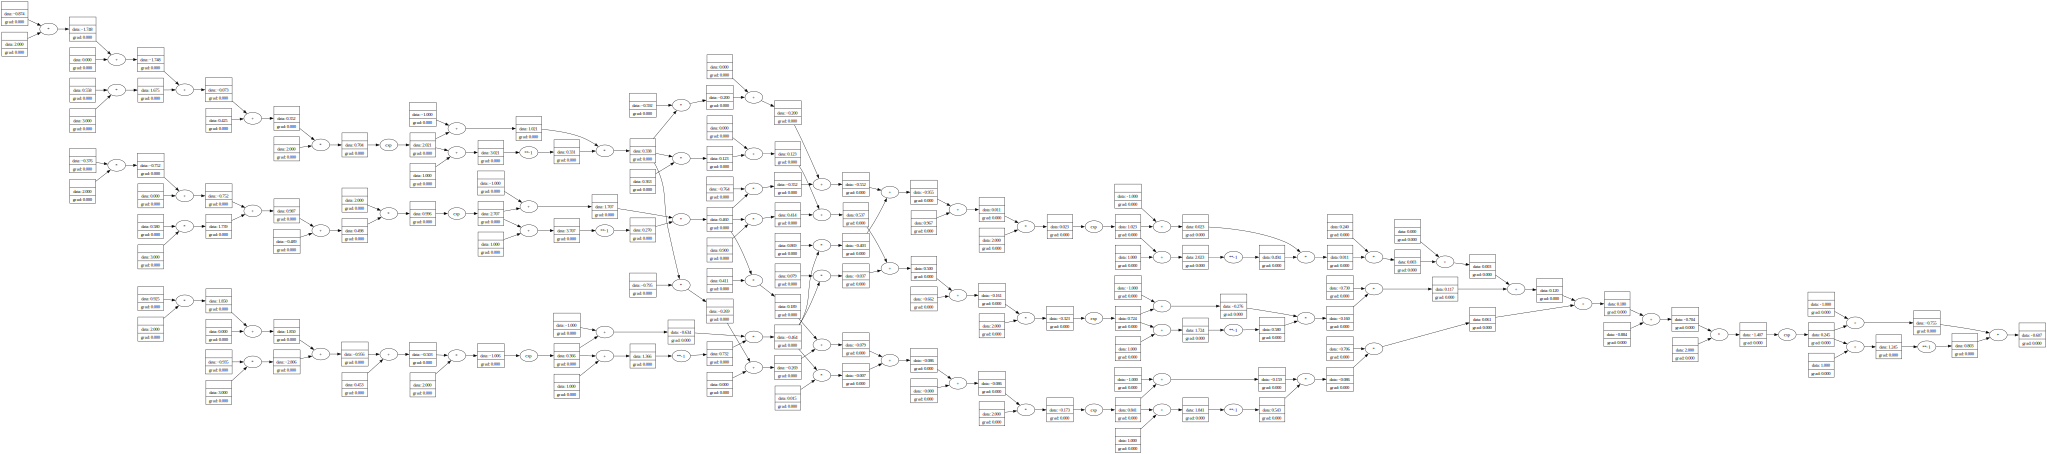

In [70]:
build_graph(n(x))

**Improve the repr formatting for better information**

In [57]:
n

MLP(Layers: [Layer([Neuron(2 W and 1 bias), Neuron(2 W and 1 bias), Neuron(2 W and 1 bias)]), Layer([Neuron(3 W and 1 bias), Neuron(3 W and 1 bias), Neuron(3 W and 1 bias)]), Layer([Neuron(3 W and 1 bias)])])